In [1]:
import scipy.linalg as la
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from helper_functions.grape_functions import *
#from main_grape.Grape_original import Grape
from helper_functions.qutip_open_verification import *
from helper_functions.qutip_mmt_verification import *
import h5py
%pylab inline

print parentdir
from IPython import display


Populating the interactive namespace from numpy and matplotlib
/home/mohamed/OQOC/OQOC_Github


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


105
last modified: Tue Oct 17 16:29:40 2017
created: Tue Oct 17 16:29:40 2017
maybe
T_f: 100, steps: 300, cavity modes: 5


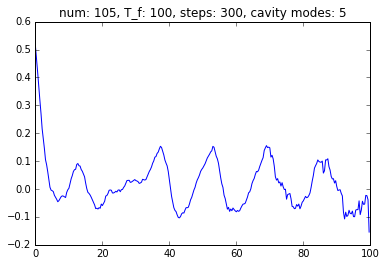

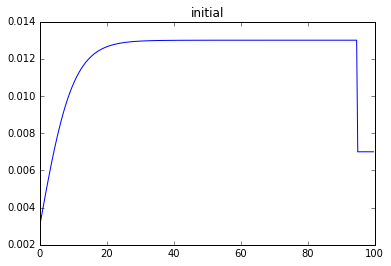

In [2]:
#93,106,101,115
#First_results2 is 100
#First_results4 is 105
from matplotlib import pyplot as plt    

for num in xrange(105,106):
    print num
    file_name = '/home/mohamed/Data/' +"%05d" % num+"_JC.h5"
    import os.path, time
    print("last modified: %s" % time.ctime(os.path.getmtime(file_name)))
    print("created: %s" % time.ctime(os.path.getctime(file_name)))
    with h5py.File(file_name,'r') as hf:

        gate_time = np.array(hf.get('total_time'))
        gate_steps = np.array(hf.get('steps'))
        H0 = np.array(hf.get('H0'))
        if len(np.array(hf.get('uks')))>24:
            uks = np.array(hf.get('uks'))[24]
            print "maybe"
        else:
            uks = np.array(hf.get('uks'))[-1]
        uks_0 = np.array(hf.get('uks'))[0]
        error = np.array(hf.get('error'))
    qubit_state_num = 2
    s = "T_f: " + str(gate_time)+", steps: "+str(gate_steps)+", cavity modes: "+str(len(H0)/2)
    print s
    #print gate_steps, len(H0),-error[-1]
    figure()
    plt.plot([(float(gate_time)/len(uks[0]))*i for i in range(len(uks[0]))],uks[0])
    plt.title("num: " + str(num)+", "+s)
    
    figure()
    plt.plot([(float(gate_time)/len(uks_0[0]))*i for i in range(len(uks[0]))],uks_0[0])
    plt.title("initial")
    mode_state_num = len(H0)/2
    a   = np.kron(np.diag(np.sqrt(np.arange(1,mode_state_num)),1),np.identity(qubit_state_num))
    adag   = np.kron(np.diag(np.sqrt(np.arange(1,mode_state_num)),-1),np.identity(qubit_state_num))

    #mmt_qutip_verification(file_name, adag+a, idx = 24 )


In [2]:
#Defining time scales
total_time = 10
steps = 1000
state_transfer = True
RWA = True
RFT = True

#Defining H0





qubit_state_num = 2

fq= 4.6/(2*np.pi)
kappa = 0.05
gamma = 0.001
g = 0.05

mode_state_num = 20
#g = 2.*np.pi*0.1 #GHz
fc = 5.0/(2*np.pi) #GHz
state_num = qubit_state_num * mode_state_num
if RFT:
    fq = fq-fc
    fc = 0
    
wc = 2*np.pi*fc
wa = 2*np.pi*fq


alpha = 0.224574
ens = np.array([ 2*np.pi*ii*(fq - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
H0q = np.kron(np.identity(mode_state_num),np.diag(ens))

a   = np.kron(np.diag(np.sqrt(np.arange(1,mode_state_num)),1),np.identity(qubit_state_num))
adag   = np.kron(np.diag(np.sqrt(np.arange(1,mode_state_num)),-1),np.identity(qubit_state_num))
sm = np.kron(np.identity(mode_state_num),np.diag(np.sqrt(np.arange(1,qubit_state_num)),1))
smdag = np.kron(np.identity(mode_state_num),np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1))

if RWA:
     H0 = wc * np.dot(adag,a) + H0q + g * (np.dot(adag,sm) + np.dot(a,smdag))
else:
     H0 = wc * np.dot(adag,a) + H0q +  g * np.dot((adag + a),(sm + smdag))
#Defining Forbidden sates


#Defining Concerned states (starting states)
psi0=[0,1]

#Defining states to include in the drawing of occupation
states_draw_list = [0,1,2]
states_draw_names = ['g0','e0','g1']




#Defining U (Target)
if state_transfer:
    U =[]
    U1 = np.zeros(state_num,dtype=complex)
    U1[1]=1
    U1[0]=0
    U.append(U1)
    U2 = np.zeros(state_num,dtype=complex)
    U2[0]=1
    U.append(U2)
    
else:
    Ut_c = la.expm((0-1j)*total_time*H0)
    Ct_c = Ut_c.copy()
    Ct_c[1,0] = 1
    Ct_c[0,1] = 1
    Ct_c[0,0] = 0
    Ct_c[1,1] = 0
    U = Ct_c

print np.shape(U)
#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num)
U0= q_identity

#Defining control Hs
IX = a + adag
IY = (0+1j)* (a-adag)
Hops = [IX]
ops_max_amp = [0.1]
Hnames =['HI']

#Defining convergence parameters
max_iterations = 500
decay = max_iterations/2
convergence = {'rate':0.05, 'update_step':1, 'max_iterations':max_iterations,\
               'conv_target':1e-10,'learning_rate_decay':decay}
reg_coeffs = {'envelope' : 0,  'dwdt':0.001*10**50,'d2wdt2':0.001*0.0001*10**50}
#, 'forbidden':100 , 'states_forbidden_list': [3]
#reg_coeffs = { 'speed_up':100}
reg_coeffs = {'envelope' : 0,  'dwdt':0,'d2wdt2':0}
#multi_mode = {'dressed':dressed, 'vectors':v_c, 'qnum':qubit_state_num, 'mnum': mode_state_num,\
              #'f':freq_ge, 'es':w_c, 'g1':qm_g1, 'D':D, 'Interpolation':True, 'Modulation':True}

    #Defining initial pulses

print len(U)
print reg_coeffs


(2, 40)
2
{'d2wdt2': 0, 'envelope': 0, 'dwdt': 0}


In [4]:
w_c, v_c, dressed_id = get_dressed_info(H0)
print w_c
print dressed_id
g0 = v_c[:,get_state_index(0,dressed_id)]
print g0
print v_c[:,get_state_index(1,dressed_id)]

[ 0.09580399+0.j -0.49580399+0.j  0.00615528+0.j -0.40615528+0.j
  0.01213203+0.j -0.41213203+0.j  0.01794495+0.j -0.41794495+0.j
  0.02360680+0.j -0.42360680+0.j  0.02912878+0.j -0.42912878+0.j
  0.03452079+0.j -0.43452079+0.j  0.03979158+0.j -0.43979158+0.j
  0.04494897+0.j -0.44494897+0.j  0.05000000+0.j -0.45000000+0.j
  0.05495098+0.j -0.45495098+0.j  0.05980762+0.j -0.45980762+0.j
  0.06457513+0.j -0.46457513+0.j  0.06925824+0.j -0.46925824+0.j
  0.07386128+0.j -0.47386128+0.j  0.07838822+0.j -0.47838822+0.j
  0.08284271+0.j -0.48284271+0.j  0.08722813+0.j -0.48722813+0.j
 -0.49154759+0.j  0.09154759+0.j  0.00000000+0.j -0.40000000+0.j]
[38, 37, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15, 18, 17, 20, 19, 22, 21, 24, 23, 26, 25, 28, 27, 30, 29, 32, 31, 34, 33, 35, 36, 0, 39]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
[ 0.         -0.99250756  0.122183

In [5]:

c_ops=[]
c_ops.append(np.sqrt(gamma)*sm)
c_ops.append(np.sqrt(kappa)*a)
#c_ops.append(ef)

#print c_ops
print gamma


0.001


(1, 1000)
0.0980940167237


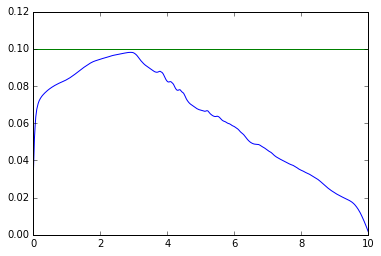

In [6]:
import h5py

with h5py.File('/home/mohamed/Data/00394_JC.h5','r') as hf:
    u0 = np.array(hf.get('uks'))[-1]

u0 = 2.2*u0

u0 = [np.interp(np.linspace(0,total_time, steps),np.linspace(0,total_time, len(u0[0])),u0[0])]
#u0 = None
print np.shape(u0)
print np.max(u0[0])
#u0 = []
#signal = 0.1*np.tanh(np.linspace(0,total_time, steps)/10)
#u0.append(signal)
#u0.append(signal)
#u0.append(2*np.ones(steps))

#u0 = None
plot (np.linspace(0,total_time, steps), u0[0])
plot (np.linspace(0,total_time, steps), 0.1*np.ones(steps))


TypeError: 'NoneType' object is not iterable

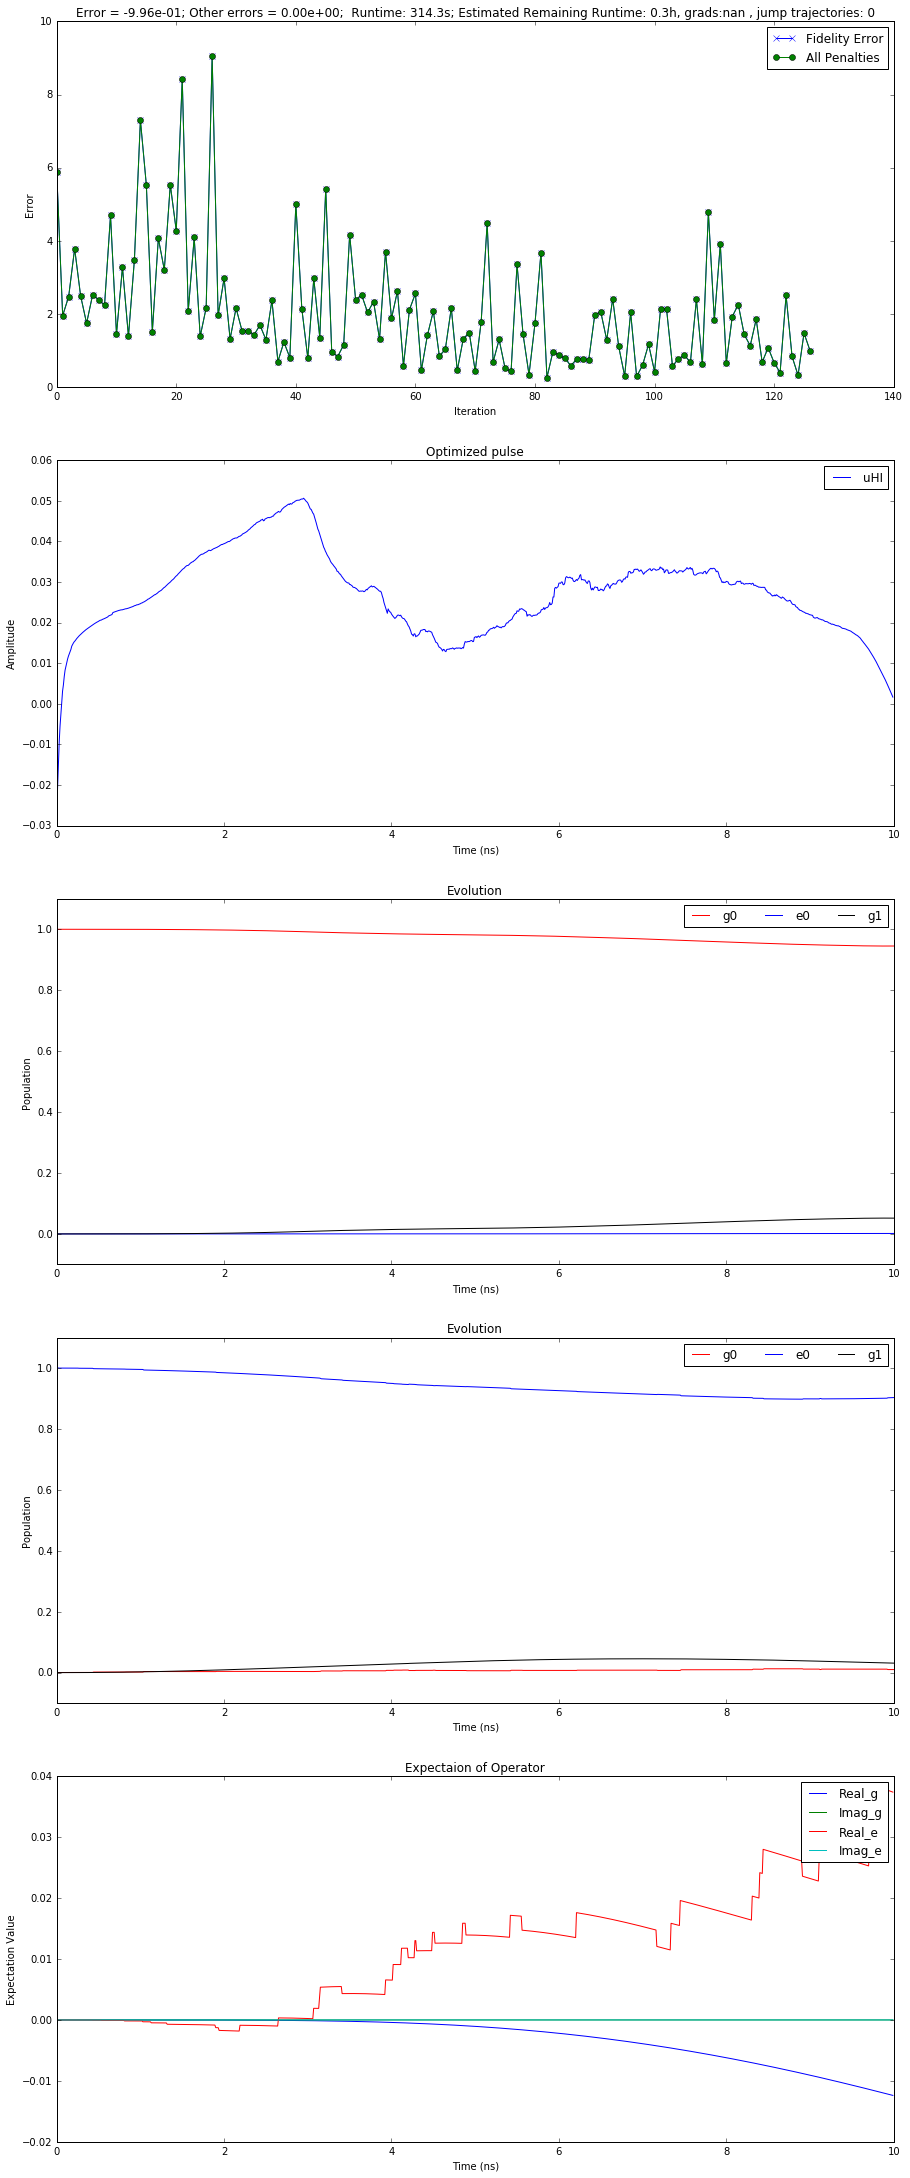

In [7]:
 #Extra options
#reg_coeffs = reg_coeffs,draw = [states_draw_list,states_draw_names] ,forbidden = states_forbidden_list,multi_mode = multi_mode,
#maxA = ops_max_amp,use_gpu = True

      
uks,U_final = Grape(H0,Hops,Hnames,U,total_time,steps,psi0,convergence=convergence, draw = [states_draw_list,states_draw_names],  
                    
                    show_plots = True, c_ops = c_ops, initial_guess = u0, use_gpu = False,
       unitary_error = 1e-4,  maxA=ops_max_amp, state_transfer = state_transfer, method ='Adam', expect_op = a + adag,
                    reg_coeffs=reg_coeffs, file_name='JC', trajectories = 10, do_all_traj = True,
                    data_path = '/home/mohamed/Data')

(30, 30)


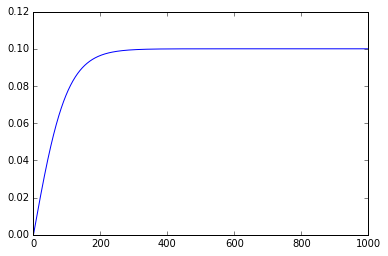

In [9]:
#398 is 200 from noise
#394 is 100 good

with h5py.File('/home/mohamed/Data/00466_JC.h5','r') as hf:
    intr = np.array(hf.get('uks'))[-1]
    H = np.array(hf.get('H0'))
plot(intr[0])
print np.shape(H)

Verifying init vector id: 0
Verifying init vector id: 1
413242.969278


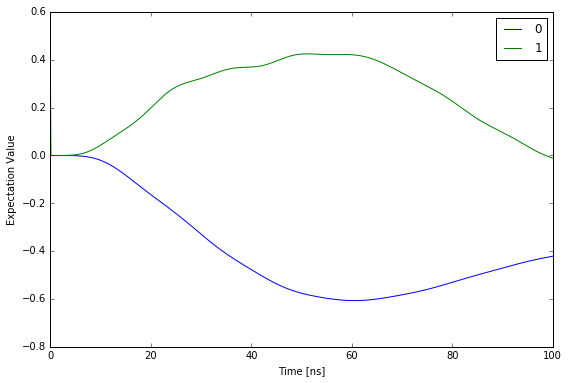

In [3]:
file_name = '/home/mohamed/Data/00466_JC.h5'
#mmt_qutip_verification(file_name, np.dot(adag,a) )
mmt_qutip_verification(file_name, adag+a )
#mmt_qutip_verification(file_name, (0+1j)* (a-adag) )

Verifying init vector id: 0
Verifying init vector id: 1
744092.722715


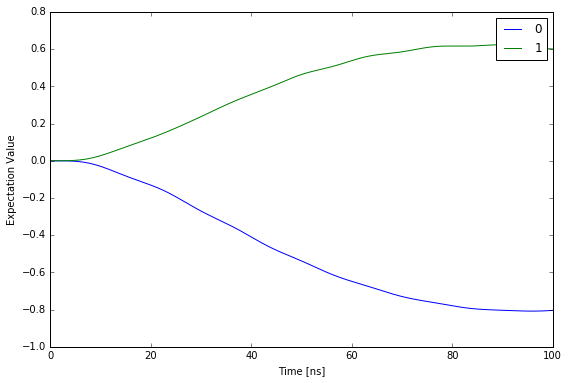

In [4]:
file_name = '/home/mohamed/Data/00485_JC.h5'
#mmt_qutip_verification(file_name, np.dot(adag,a) )
mmt_qutip_verification(file_name, adag+a )
#mmt_qutip_verification(file_name, (0+1j)* (a-adag) )